# Exploring Bayesian Optimization

### ***Laura Battaglia, Yabra Muvdi, Maria Salunina***

Bayesian optimization is a very powerful technique to efficiently acquire information from an objective function that is extremely expensive to evaluate. By gradually collecting samples, we can update our beliefs on the unknown objective function and compute a posterior distribution over it. This posterior distribution serves as a fundamental input for constructing an acquisition function to decide where to sample from. Consequently, the acquisition function plays a fundamental role in the Bayesian optimization (BO) framework; it guides the process of information acquisition. 

Analyzed from the multi-armed bandit perspective, this function is in charge of balancing the inherent tradeoff between exploration and exploitation. Should we keep sampling from places where we already know that the function has relatively high values? Or should we instead sample from places where we have high uncertainty? This makes the choice of acquisition function far from trivial. Multiple options have been proposed in the literature, but there is no single choice that fits all types of functions.

In this project, we aim to explore an approach to this problem proposed by Auer et al. (1998): using an adaptative portfolio of acquisition functions. We will rely on the implementation proposed by [Hoffman et al. (2011)](https://arxiv.org/pdf/1009.5419.pdf) and will show its performance on three classic functions in the literature (Branin, Hartman 3, and Hartman 6) and compare it to that of individual acquisition functions. Further, we will make the portfolio strategy face an utterly different adversary: stochastic gradient descent. As the authors mention, the nature of these functions should cause gradient methods to perform much worse than Bayesian optimization strategies. We will test this claim empirically. 

Finally, we will try to combine both Bayesian optimization strategies with gradient methods to construct a methodology that uses the best of both worlds. Concretely, we will use Bayesian optimization to select candidates from which we can start a gradient descent process.

In [ ]:
# Relevant packages

import pandas as ps
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.stats as ss
import matplotlib.pyplot as plt
import torch
from datetime import datetime

import seaborn as sns
# sns.set_context("notebook")
plt.style.use('classic') #bmh
sns.set_style("white")
sns.set_context("talk")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel

## 1. Test functions

We start by describing and implementing the three functions that we will use to test our optimization strategies. These functions are use broadly in the literature; including Hoffman et al. (2011).

[Branin_2D](https://www.sfu.ca/~ssurjano/branin.html) <br>

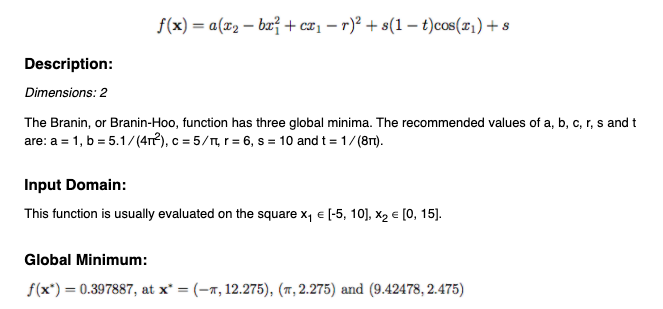

[Hartman 3D](https://www.sfu.ca/~ssurjano/hart3.html) <br>

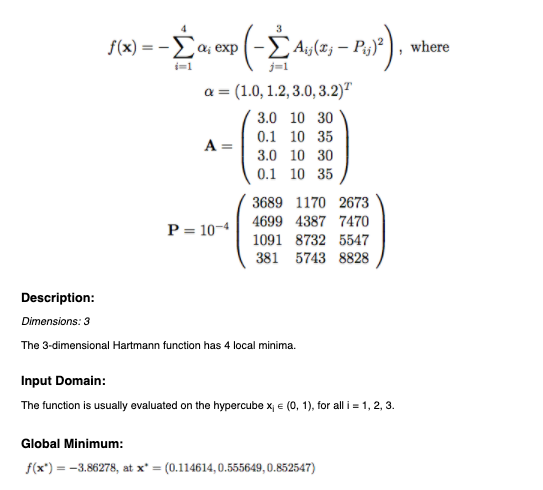

[Hartman 6D](https://www.sfu.ca/~ssurjano/hart6.html)

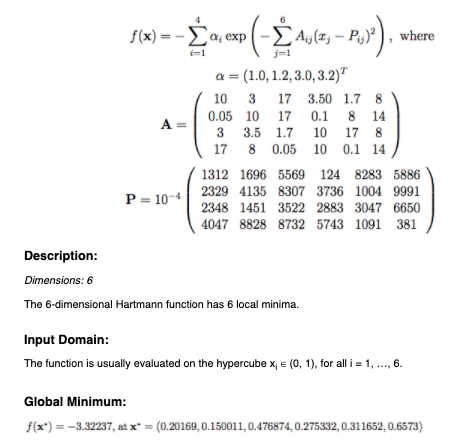

In [2]:
def branin(x, gd=False):
    """ Implementation of the 2D Branin function. If the 
        gd(Gradient Descent) option is set to true, then 
        the output is transformed into tensors and is kept 
        as a minimization problem
    """
    
    x_1, x_2 = x[0], x[1]
    
    if gd:
        pi = torch.Tensor([np.pi])
        a, b, c, r, s, t = (1, 5.1 / (4 * pi**2), 5 / pi, 6, 10, 1 / (8 * pi))
        f = a * (x_2 - b * x_1**2 + c * x_1 - r)**2 + s * (1 - t) * torch.cos(x_1) + s
        f = f[0] # solve minimization problem 
        
    else:
        x_1, x_2 = x[0], x[1]
        a, b, c, r, s, t = (1, 5.1 / (4 * np.pi**2), 5 / np.pi, 6, 10, 1 / (8 * np.pi))
        f = -(a * (x_2 - b * x_1**2 + c * x_1 - r)**2 + s * (1 - t) * np.cos(x_1) + s)  # solve maximization problem
    
    return f

def hartman(x, htype='hartman-3', gd=False):
    """ Implementation of the Hartman functions. Both the
        3D and the 6D versions are implemented. If the 
        gd(Gradient Descent) option is set to true, then 
        the output is transformed into tensors and is kept 
        as a minimization problem
    """
    
    if htype == 'hartman-3':
        alpha = np.array([1, 1.2, 3, 3.2])
        A = np.array([[ 3, 10, 30],
                      [.1, 10, 35],
                      [ 3, 10, 30],
                      [.1, 10, 35]])
        P = np.array([[.3689, .1170, .2673],
                      [.4699, .4387, .7470],
                      [.1091, .8732, .5547],
                      [.0381, .5743, .8828]])
    elif htype == 'hartman-6':  
        alpha = np.array([1, 1.2, 3, 3.2])
        A = np.array([[ 10,   3,  17, 3.5, 1.7,  8],
                      [.05,  10,  17,  .1,   8, 14],
                      [  3, 3.5, 1.7,  10,  17,  8],
                      [ 17,   8, .05,  10,  .1, 14]])
        P = np.array([[.1312, .1696, .5569, .0124, .8283, .5886],
                      [.2329, .4135, .8307, .3736, .1004, .9991],
                      [.2348, .1451, .3522, .2883, .3047, .6650],
                      [.4047, .8828, .8732, .5743, .1091, .0381]])
    else:
        raise Exception('Dimension should be 3D or 6D')
        
    if gd:
        A = torch.tensor(A.copy())
        P = torch.tensor(P.copy())
        f = 0
        for i in range(4):
            f += alpha[i] * torch.exp(torch.matmul(-A[i],(x - P[i])**2))
        f = -f # solve minimization problem 
    
    else:
        f = sum([alpha[i] * np.exp(-A[i] @ (x - P[i])**2) for i in range(4)]) # solve maximization problem
        
    return f

## 2. Bayesian optimization framework

We now turn to the implementation of a Bayesian optimization framework using Gaussian Processes (GP's). We will rely on the scikit-learn implementation of GP's and will use a Squared Exponential (SE) kernel with a very small added noise to avoid stability problems. The hyperparameters of this kernel are optimized within the GP updates.

Given the objective of our project, we will implement three different options of simple acquisition functions: 

- **Probability of Improvement (PI)**: This acquisition function tries to maximize the probability of improving over the incumbent. This general strategy will potentially lead to focusing on exploitation and thus a $\epsilon$ parameter is added to balance exploration and exploitation. We will start by setting this parameter to $\epsilon = 0.01$ to match the figures from Hoffman et al. (2011).

- **Expected Improvement (EI)**: In addition to considering the probability of improvement, an acquisition function can also take into account the magnitude of this potential improvement. EI tries to improve PI by taking this aspect into account. As in the case of PI, a parameter $\epsilon$ is added in order to balance exploration and exploitation.We will start by setting this parameter to $\epsilon = 0.01$ to match the figures from Hoffman et al. (2011).

- **Upper Confidence Bound (UCB)**: This acquisition function is a great exponent of the principal of *optimism in the face of uncertainty*; choosing actions as if the best plausible scenarios will indeed materialize. We will thus try to sample those points where the upper confidence bound is higher. We set parameters $\delta = 0.1$ and $v = 0.2$, again, to follow the work from Hoffman et al. (2011).

In addition, we try the **GP-Hedge strategy** proposed by Hoffman et al. (2011) that envisages the use of a portfolio of acquisition functions: given that we know that no single acquisition function is appropriate for all problems, we could mix our usage of these functions. We can thus, treat this problem as a multi-arm bandit one in which each acquisition function is an arm. Interestingly, this makes the whole optimization problem a hierarchical multi-armed bandit one. At the first level we need to choose the acquisition function and at the second level we need to choose where to sample. We describe below the GP-Hedge algorithm.

**Algorithm 1 GP-Hedge**
***
- select parameter $\eta \in \mathbb{R}^{+}$
- set cumulative gains of every acquisition function to zero: $g_{0}^{i} = 0$ for $i = 1,...,K$
- **for** $t = 1,2,...$ **do**
    - nominate the best candidate point from each acquisition function
    - select nominee $x_{t}^{j}$ with probability $p_{t}(j) = \frac{exp(\eta g_{t-1}^{j})}{\sum_{i=1}^{K} exp(\eta g_{t-1}^{i})}$
    - sample the objective function in the selected point
    - augment the data with the new pair ($x_t, y_t$)
    - update the GP
    - receieve rewards $r_{t}^{j} = \mu_{t}(x_{t}^{j})$
    - update cumulative gains $g_{t}^{j} = g_{t-1}^{j} + r_{t}^{j}$
- **end for**
***

Intuitively, this algorithm is assigning probabilities to each acquisition function according to their accumulated gains and then randomly drawing one of these functions with those probabilities. Thus, those acquisition functions that have showed higher rewards through the sampling process will have higher probabilities of getting their nominee choosen.  It is worth noticing that while in the conventional Bayesian optimization setting the objective function is sampled only once per iteration, GP-Hedge is a full information strategy and requires a reward for every action (i.e. for every acquisition function candidate) at every time step. The authors achieve this by defining the reward at $x^j_t$ as the expected value of the GP model at $x^j_t$ i.e. $\mu(x^j_t)$.

In [1]:
class BayesianOptimisation():
    """ Class for performing all the steps required when doing
        Bayesian optimization with Gaussian Processes (GP).
        The class allows for several choices of acquisition functions,
        as well as three different objective functions.
    """
    
    def __init__(self, kernel_noise=0.01, method='UCB', obj_func='branin-2', eta=.001):
        '''set exploration parameters, optimum value, and GP kernel noise'''
        self.method = method
        self.obj_func = obj_func
        self.kernel_noise = kernel_noise
        
        if self.obj_func == 'branin-2':
            self.optimum = -0.39788735775266204
        elif self.obj_func == 'hartman-3':
            self.optimum = 3.8627797869493365
        elif self.obj_func == 'hartman-6':
            self.optimum = 3.322368011391339
        else:
            raise Exception('Invalid objective function!')
        if (method == 'GP_Hedge3') | (method == 'GP_Hedge9'):
            self.eta = eta
            
    
    def get_grid(self, step=100):
        '''get grid points depending on the provided step'''
        if self.obj_func == 'branin-2':
            x1 = np.linspace(-5, 10, num=step)
            x2 = np.linspace(0, 15, num=step)
            xx1, xx2 = np.meshgrid(x1, x2)
            X_train = np.stack([xx1.reshape(-1), xx2.reshape(-1)]).T
            
        elif self.obj_func == 'hartman-3':
            x = np.linspace(0, 1, num=step)
            xx1, xx2, xx3 = np.meshgrid(x, x, x)
            X_train = np.stack([xx1.reshape(-1), xx2.reshape(-1), xx3.reshape(-1)]).T
            
        elif self.obj_func == 'hartman-6':
            x = np.linspace(0, 1, num=step)
            xx1, xx2, xx3, xx4, xx5, xx6 = np.meshgrid(x, x, x, x, x, x)
            X_train = np.stack([xx1.reshape(-1), xx2.reshape(-1), xx3.reshape(-1),
                                xx4.reshape(-1), xx5.reshape(-1), xx6.reshape(-1)]).T
        return X_train
    
    def get_y(self, x):
        '''get value of the objective function'''
        if self.obj_func == 'branin-2':
            y = branin(x)
        elif self.obj_func == 'hartman-3':
            y = hartman(x, htype='hartman-3')
        elif self.obj_func == 'hartman-6':
            y = hartman(x, htype='hartman-6')
        return y
    
    def ucb_af(self, X_, y_mean, sigma, t, v=.2):
        '''UCB acquisition function'''
        D = X_.shape[1]
        delta = .1
        beta_t = 2*np.log(t**(D/2+2) * np.pi**2 / 3 * delta)
        eps = np.sqrt(v * beta_t)
        UCB = y_mean + eps*sigma
        max_x = np.argmax(UCB)
        next_x = X_[max_x]
        return next_x
    
    def pi_af(self, X_, y_mean, sigma, y_train, eps=0.01):
        '''PI acquisition function'''
        best_so_far = np.max(y_train)
        z = (y_mean - best_so_far - eps)/sigma
        PI = ss.norm.cdf(z)
        next_x = X_[np.argmax(PI)]
        return next_x
    
    def ei_af(self, X_, y_mean, sigma, y_train, eps=0.01):
        '''EI acquisition'''
        best_so_far = np.max(y_train)
        z = (y_mean - best_so_far - eps)/sigma
        PI = ss.norm.cdf(z)
        pdf = ss.norm.pdf(z)
        EI = (y_mean - best_so_far - eps)*PI + sigma*pdf 
        next_x = X_[np.argmax(EI)]
        return next_x
    
    def gp_hedge_3(self, X_, y_mean, sigma, y_train, t):
        '''GP-Hedge 3'''
        ucb_next_x = self.ucb_af(X_, y_mean, sigma, t, v=.2)
        pi_next_x = self.pi_af(X_, y_mean, sigma, y_train, eps=.01)
        ei_next_x = self.ei_af(X_, y_mean, sigma, y_train, eps=.01)
        
        self.nominees = [ucb_next_x, pi_next_x, ei_next_x]
        af_probabilities = np.exp(self.eta * self.gains) / np.sum(np.exp(self.eta * self.gains))
        self.probabilities.append(af_probabilities)
        drawed_arm = np.random.multinomial(n=1, pvals=af_probabilities)
        next_x = self.nominees[np.where(drawed_arm == 1)[0][0]]
        
        return next_x
    
    def gp_hedge_9(self, X_, y_mean, sigma, y_train, t):
        '''GP-Hedge 9'''
        ucb_next_x_1 = self.ucb_af(X_, y_mean, sigma, t, v=.2)
        ucb_next_x_2 = self.ucb_af(X_, y_mean, sigma, t, v=.1)
        ucb_next_x_3 = self.ucb_af(X_, y_mean, sigma, t, v=1)
        
        pi_next_x_1 = self.pi_af(X_, y_mean, sigma, y_train, eps=.01)
        pi_next_x_2 = self.pi_af(X_, y_mean, sigma, y_train, eps=.1)
        pi_next_x_3 = self.pi_af(X_, y_mean, sigma, y_train, eps=1)
        
        ei_next_x_1 = self.ei_af(X_, y_mean, sigma, y_train, eps=.01)
        ei_next_x_2 = self.ei_af(X_, y_mean, sigma, y_train, eps=.1)
        ei_next_x_3 = self.ei_af(X_, y_mean, sigma, y_train, eps=1)
        
        self.nominees = [ucb_next_x_1, ucb_next_x_2, ucb_next_x_3,
                         pi_next_x_1, pi_next_x_2, pi_next_x_3,
                         ei_next_x_1, ei_next_x_2, ei_next_x_3]
        af_probabilities = np.exp(self.eta * self.gains) / np.sum(np.exp(self.eta * self.gains))
        self.probabilities.append(af_probabilities)
        drawed_arm = np.random.multinomial(n=1, pvals=af_probabilities)
        next_x = self.nominees[np.where(drawed_arm == 1)[0][0]]
        
        return next_x
    
    def optimize_AF(self, X_, y_mean, sigma, y_train, t):
        '''optimise chosen acquisition function'''
        if self.method == 'UCB':
            next_x = self.ucb_af(X_, y_mean, sigma, t)
        elif self.method == 'PI':
            next_x = self.pi_af(X_, y_mean, sigma, y_train)
        elif self.method == 'EI':
            next_x = self.ei_af(X_, y_mean, sigma, y_train)
        elif self.method == 'GP_Hedge3':
            next_x = self.gp_hedge_3(X_, y_mean, sigma, y_train, t)
        elif self.method == 'GP_Hedge9':
            next_x = self.gp_hedge_9(X_, y_mean, sigma, y_train, t)
        return next_x 
    
    def get_optimum(self, grid_step=100, num_iters=100, samples=25):
        '''for a given AF and exploration parameters, run algorithm and 
        obtain visited points and related function values'''
        
        np.random.seed(13)
        results = []
        for _ in range(samples):
            self.kernel = ConstantKernel(1.0, constant_value_bounds = (0.0001, np.inf)) * \
                            RBF(1.0, length_scale_bounds=(0.00001, np.inf))\
                            + WhiteKernel(noise_level=self.kernel_noise, noise_level_bounds='fixed')
            if self.method == 'GP_Hedge3':
                self.probabilities = []
                self.gains = np.zeros(3) # 3 obj_funcs
                
            if self.method == 'GP_Hedge9':
                self.probabilities = []
                self.gains = np.zeros(9)
            
            X_ = self.get_grid(step=grid_step)
            if self.obj_func == 'branin-2':
                x1 = [np.random.uniform(-5, 10), np.random.uniform(0, 15)]
            elif self.obj_func == 'hartman-3':
                x1 = np.random.uniform(low=0, high=1, size=3)
            elif self.obj_func == 'hartman-6':
                x1 = np.random.uniform(low=0, high=1, size=6)
            X_train = np.array([x1])
            y_train = [self.get_y(X_train[0]) + np.random.normal(0, .5)]
            f_wo_noise = [self.get_y(X_train[0])]

            f_1 = f_wo_noise[0]
            f_best = max(f_wo_noise)
            gap_0 = (f_best - f_1) / (self.optimum - f_1)
            gap = [gap_0]

            GP = GaussianProcessRegressor(kernel=self.kernel, optimizer='fmin_l_bfgs_b', random_state=2)
            for t in range(num_iters):
                GP.fit(X_train, y_train)

                # get canidates
                y_mean, sigma = GP.predict(X_, return_std=True)
                next_x = self.optimize_AF(X_, y_mean, sigma, y_train, t)

                # sampling
                X_train = np.vstack((X_train, next_x))
                y_ = self.get_y(next_x) + np.random.normal(0, .5)
                y_train.append(y_)
                f_wo_noise.append(self.get_y(next_x))

                if (self.method == 'GP_Hedge3') | (self.method == 'GP_Hedge9'):
                    GP.fit(X_train, y_train)
                    nominees_rewards = GP.predict(self.nominees)
                    self.gains = np.array([gain + nominees_rewards[i] for i, gain in enumerate(self.gains)])

                f_best = max(f_wo_noise)
                gap_t = (f_best - f_1) / (self.optimum - f_1)
                gap.append(gap_t)
            results.append(gap)
         
        results = np.array(results)
        
        if (self.method == 'GP_Hedge3') | (self.method == 'GP_Hedge9'):
            return results.mean(axis=0), results.var(axis=0), self.probabilities
        else:
            return results.mean(axis=0), results.var(axis=0)

## 3. Comparing Strategies

Now that we have a setup for performing Bayesian optimization with different strategies, we can compare their perfomance on the test functions. This comparison will resemble Figure 2 from Hoffman et al. (2011). Concretely, we will use the following strategies:

- **Probability Improvement (PI)** with parameters: $\epsilon = 0.01$
- **Expected Improvement (EI)** with parameters: $\epsilon = 0.01$
- **Upper Confidence Bound (UCB)** with parameters: $\delta = 0.1$ and $v = 0.2$
- **GP-Hedge 3** choosing from the three acquistion functions described above and parameter $\eta = 0.001, 0.04$ and $0.05$ for Branin, Hartman-3 and Hartman-6 respectively 
- **GP-Hedge 9** choosing again from the three acquisition functions above plus four acquisition functions consisting on both PI and EI with $\epsilon = 0.1 $ and $\epsilon = 1$ and two addition UCB's with $v = 0.1$ and $v = 1.0$. Here the $\eta$ parameter is equal to $0.001, 0.04$ and $0.03$ for Branin, Hartman-3 and Hartman-6 respectively 


In order to compare the performance of these acquisition functions we will use the "gap" metric proposed by Hoffman et al. (2011). This metric is defined as follows:

$$ G_{t} =  \frac{ \left [ f(x^{+}) - f(x_{1}) \right ]}{\left [ f(x^{*}) - f(x_{1}) \right ]}  $$

where $x^{+}$ is the best point found up to time $t$, $x^{*}$ is the optimal point and $x_{1}$ is the initial point. Conveniently, this metric is bounded between 0 and 1. Our plots will reflect this.

### Branin

In [229]:
branin_bo_ucb = BayesianOptimisation(kernel_noise=0.01, obj_func='branin-2', method='UCB')
branin_mean_ucb, branin_var_ucb = branin_bo_ucb.get_optimum(samples=5, grid_step=100)

In [230]:
branin_bo_ei = BayesianOptimisation(kernel_noise=0.01, obj_func='branin-2', method='EI')
branin_mean_ei, branin_var_ei = branin_bo_ei.get_optimum(samples=5, grid_step=100)

In [231]:
branin_bo_pi = BayesianOptimisation(kernel_noise=0.01, obj_func='branin-2',  method='PI')
branin_mean_pi, branin_var_pi = branin_bo_pi.get_optimum(samples=5, grid_step=100)

In [232]:
branin_bo_hedge3 = BayesianOptimisation(kernel_noise=0.01, obj_func='branin-2', method='GP_Hedge3', eta=.001)
branin_mean_hedge3, branin_var_hedge3, branin_probs3 = branin_bo_hedge3.get_optimum(samples=10, grid_step=100)

In [233]:
branin_bo_hedge9 = BayesianOptimisation(kernel_noise=0.01, obj_func='branin-2', method='GP_Hedge9', eta=.001)
branin_mean_hedge9, branin_var_hedge9, branin_probs9 = branin_bo_hedge9.get_optimum(samples=10, grid_step=100)

### Hartman-3

In [234]:
h3_bo_ucb = BayesianOptimisation(kernel_noise=0.01, obj_func='hartman-3', method='UCB')
h3_mean_ucb, h3_var_ucb = h3_bo_ucb.get_optimum(samples=10, grid_step=25)

In [235]:
h3_bo_ei = BayesianOptimisation(kernel_noise=0.014, obj_func='hartman-3', method='EI')
h3_mean_ei, h3_var_ei = h3_bo_ei.get_optimum(samples=10, grid_step=25)

In [236]:
h3_bo_pi = BayesianOptimisation(kernel_noise=0.012, obj_func='hartman-3',  method='PI')
h3_mean_pi, h3_var_pi = h3_bo_pi.get_optimum(samples=10, grid_step=25)

In [237]:
h3_bo_hedge3 = BayesianOptimisation(kernel_noise=0.011, obj_func='hartman-3', method='GP_Hedge3', eta=.04)
h3_mean_hedge3, h3_var_hedge3, h3_probs3 = h3_bo_hedge3.get_optimum(samples=10, grid_step=25)

In [238]:
h3_bo_hedge9 = BayesianOptimisation(kernel_noise=0.0109, obj_func='hartman-3', method='GP_Hedge9', eta=.04)
h3_mean_hedge9, h3_var_hedge9, h3_probs9 = h3_bo_hedge9.get_optimum(samples=10, grid_step=25)

### Hartman-6

In [239]:
h6_bo_ucb = BayesianOptimisation(kernel_noise=0.01, obj_func='hartman-6', method='UCB')
h6_mean_ucb, h6_var_ucb = h6_bo_ucb.get_optimum(samples=10, grid_step=5)

In [240]:
h6_bo_ei = BayesianOptimisation(kernel_noise=0.01, obj_func='hartman-6', method='EI')
h6_mean_ei, h6_var_ei = h6_bo_ei.get_optimum(samples=10, grid_step=5)

In [241]:
h6_bo_pi = BayesianOptimisation(kernel_noise=0.0109, obj_func='hartman-6',  method='PI')
h6_mean_pi, h6_var_pi = h6_bo_pi.get_optimum(samples=10, grid_step=5)

In [242]:
h6_bo_hedge3 = BayesianOptimisation(kernel_noise=0.0109, obj_func='hartman-6', method='GP_Hedge3', eta=.05)
h6_mean_hedge3, h6_var_hedge3, h6_probs3 = h6_bo_hedge3.get_optimum(samples=10, grid_step=5)

In [243]:
h6_bo_hedge9 = BayesianOptimisation(kernel_noise=0.01, obj_func='hartman-6', method='GP_Hedge9', eta=.03)
h6_mean_hedge9, h6_var_hedge9, h6_probs9 = h6_bo_hedge9.get_optimum(samples=10, grid_step=5)

### Replicated figure

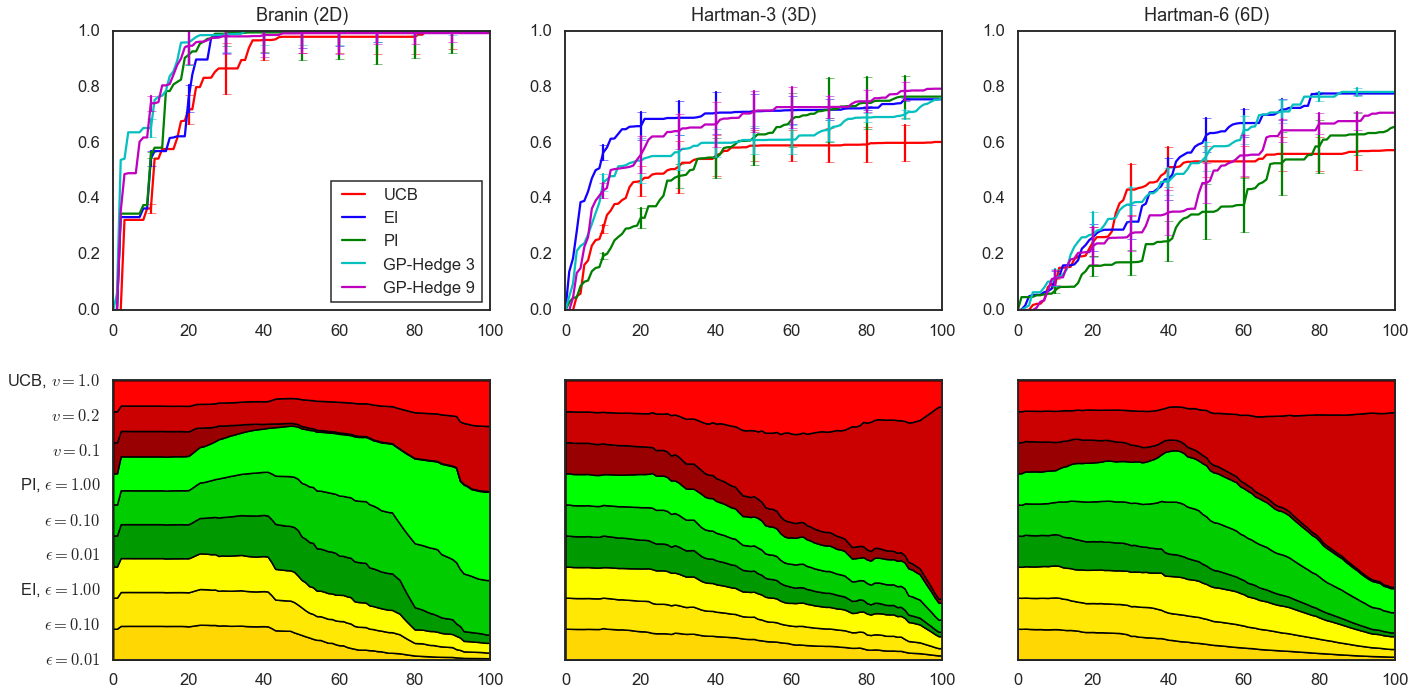

In [244]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

### FIRST ROW
colors = ['#FF0100', '#1300FF', '#008000', '#06BFBF', '#BF00BF']
names = ['UCB', 'EI', 'PI', 'GP-Hedge 3', 'GP-Hedge 9']

branin_means = [branin_mean_ucb, branin_mean_ei, branin_mean_pi, 
                branin_mean_hedge3, branin_mean_hedge9]
branin_vars = [branin_var_ucb, branin_var_ei, branin_var_pi, 
               branin_var_hedge3, branin_var_hedge9]

hartman3_means = [h3_mean_ucb, h3_mean_ei, h3_mean_pi, h3_mean_hedge3, h3_mean_hedge9]
hartman3_vars = [h3_var_ucb, h3_var_ei, h3_var_pi, h3_var_hedge3, h3_var_hedge9]
        
hartman6_means = [h6_mean_ucb, h6_mean_ei, h6_mean_pi, h6_mean_hedge3, h6_mean_hedge9]
hartman6_vars = [h6_var_ucb, h6_var_ei, h6_var_pi, h6_var_hedge3, h6_var_hedge9]
        
func_means = [branin_means, hartman3_means, hartman6_means]
func_vars = [branin_vars, hartman3_vars, hartman6_vars]
titles = ['Branin (2D)', 'Hartman-3 (3D)', 'Hartman-6 (6D)']
for j, means in enumerate(func_means):
    ax[0][j].set_title(titles[j], pad=10)
    ax[0][j].set_ylim(0, 1)
    for i, mean in enumerate(means):
        ax[0][j].plot(mean, label=names[i], c=colors[i])
        for _ in np.arange(10, 100, 10):
            ax[0][j].axvline(x=_, marker='_', c=colors[i],
                             ymin=mean[_] - hartman6_vars[i][_], 
                             ymax=mean[_] + hartman6_vars[i][_])
ax[0][0].legend(loc='lower right')

### SECOND ROW
labels = ['$\epsilon=0.01$', '$\epsilon=0.10$', 'EI, $\epsilon=1.00$', 
          '$\epsilon=0.01$', '$\epsilon=0.10$', 'PI, $\epsilon=1.00$',
          '$v=0.1$', '$v=0.2$', 'UCB, $v=1.0$',]
colors = ['#FFD702', '#FFE804', '#FEFE00',
          '#009900', '#00CC00', '#00FF00',
          '#990001', '#CB0000', '#FF0100']

branin_prob = np.array(branin_probs9 + [branin_probs9[-1]])
branin_prob = [branin_prob[:, i] for i in reversed(range(9))]

hartman3_prob = np.array(h3_probs9 + [h3_probs9[-1]])
hartman3_prob = [hartman3_prob[:, i] for i in reversed(range(9))]

hartman6_prob = np.array(h6_probs9 + [h6_probs9[-1]])
hartman6_prob = [hartman6_prob[:, i] for i in reversed(range(9))]

prob_data = [branin_prob, hartman3_prob, hartman6_prob]
for i, data in enumerate(prob_data):
    ax[1][i].stackplot(range(101), data, labels=labels, colors=colors, edgecolor='black')
    ax[1][i].set_yticks([])
    ax[1][i].set_xlim(0, 100)
ax[1][0].set_yticks(np.linspace(0, 1, 9))
ax[1][0].set_yticklabels(labels)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.25)

The plots above aimed at replicating the results presented by Hoffman et al. (2011) Figure 2. The first row of plots shows the performance of each one of the strategies on the test functions. Our measure of performance is the gap metric described above. For each acquisition function we performed the optimization process 10 times and computed the mean and variance. The results are shown in the plot. As expected, all acquisition functions perform better in the easiest function (Branin) and considerably diminish their performance in the Hartman functions.  GP-Hedge (both 3 and 9) seem to outperform the rest of the acquisition functions in the Branin case, while for Hartman functions its performance lies somewhat in the middle of the other strategies. 

The second row of plots explores in detail the inner functioning of the GP-Hedge 9. The colored bands represent the probability of each acquisition function at each iteration for a single optimization process. For the Branin function, the use of each acquistion function is balanced for 20 iterations and, afterwards, the probability of choosing the UCB with $v = 0.1$ goes to zero and the probabilities of PI's increase. At the same the probabilities of the EI start to decrease. This general dynamic suggests that the GP-Hedge learned quickly that PI's acquisition functions were doing a better job. This intuition can be confirmed by observing the performance of the PI by itself which is, indeed, better than EI or UCB after a few initial iterations. The case of both Hartman functions is different. From iteration 20 onwards, GP-Hedge starts to favor the UCB acquisition functions. Specifically, it starts rapidly increasing the probability for the UCB with parameter $v = 0.2$. However, here GP-Hedge reveals its drawbacks, as for the second half of the iterations, UCB flattens its performance and all of the other acquisition functions outperform it. This change in performance is, nevertheless, not reflected in the probabilities calculated by GP-Hedge. This is due to the fact that probabilities in GP-Hedge are calculated using the accumulated gains and, thus, it is difficult to revert trends.


It is also important to note that a further optimization of hyperparameters could greatly benefit the performance of all acquisition functions. In particular, we noticed that the $\eta$ hyperparameter of the GP-Hedge algorithm is extremely important. Indeed, it scales the gains of each acquisition functions before feeding them to the softmax transformation that determines the probabilities from which GP-Hedge will draw the winning acquisition function at each round. For high $\eta$, due to the exponential transformation within the softmax, we noticed that the algorithm will tend to assign a very high probability to a specific acquisition function and very low probability to the others, so that the advantages of a portfolio strategy are substantially zeroed. In turn, for low $\eta$ very similar probabilities will likely be assigned to each acquisition function. The role of such hyperparameter thus needs to be explored in-depth when using this algorithm.


Finally, we were also able to notice that BO algorithms present a computational disadvantage, in that for functions in many dimensions searching a fine grid of points is computationally very intensive and creates instability in the GP updates. We were therefore constrained to a sparse grid where few points could be searched, especially for Hartman-6 objective function. This adds up to the difficulty of the task and contributes to explain the worse performance of BO for more complicated functions.

## 4. Gradient-based methods

An important motivation for perfoming BO is the fact that some functions might generate serious problems for traditional gradient methods. Functions with multiple modes and large plateaus between them are, for example, very complicated cases for gradient-based methods. We want to empirically test this idea by performing gradient descent on the test functions we have been using. The class below implements the general framework for performing gradient descent using PyTorch.

In [4]:
class GradientDescent:
    """ Class for performing gradient descent over the three objective 
        functions. Optimization is obtained via Pytorch gradient approximation
        making use of the Adam optimizer. The class outputs performance in terms
        of gaps over a number of iterations and averaged across samples.
    """ 
    
    def __init__(self, obj_func='branin-2'):
        '''define optimum for each objective function'''
        self.obj_func = obj_func
        if self.obj_func == 'branin-2':
            self.opt = 0.39788735775266204
        elif self.obj_func == 'hartman-3':
            self.opt = -3.8627797869493365
        elif self.obj_func == 'hartman-6':
            self.opt = -3.322368011391339
        else:
            raise Exception('Invalid objective function!')
            
    def _train_iter(self, obj_func):
        '''compute gradients and make a gradient step'''
        if self.obj_func == 'branin-2':
            self.obj_func_val = branin(self.x_0, gd=True)
        
        elif ((self.obj_func == 'hartman-3') | (self.obj_func == 'hartman-6')):
            self.obj_func_val = hartman(self.x_0, htype=self.obj_func, gd=True)
        
        self.optimizer.zero_grad()
        self.obj_func_val.backward()
        self.optimizer.step()
    
    def train(self):
        '''compute n_iters gradient steps'''
        self.gaps_one_sample = []
        for i in range(self.n_iters):
            self.best_func_so_far = np.inf
            self._train_iter(self.obj_func)
            if self.obj_func_val.detach().numpy() < self.best_func_so_far:
                self.best_func_so_far = self.obj_func_val.detach().numpy()
            self.gaps_one_sample.append((self.best_func_so_far - self.f_0)/
                       (self.opt - self.f_0))
                
    def evaluate_performance(self, lr=0.005, n_samples=25, n_iters=100):
        '''compute n_iters gradient steps for each n_sample and store
        performance per iteration in terms of average gap and gap variance'''
        self.n_iters = n_iters
        self.n_samples = n_samples
        self.lr = lr
        
        np.random.seed(13)
        
        self.lr = lr
        gaps = []
        self.best_values = []
        
        for s in range(self.n_samples):
            if self.obj_func == 'branin-2':
                x1 = np.random.uniform(low=-5, high=10, size=1)
                x2 = np.random.uniform(low=0, high=15, size=1)
                x_start = np.column_stack((x1, x2)).flatten()
                self.f_0 = -branin(x_start, gd=False) # save initial value for performance evaluation
                
                start = x_start.copy()
                self.x_0 = torch.tensor(start).requires_grad_(True)
                self.optimizer = torch.optim.Adagrad([self.x_0] , lr=self.lr)

            elif self.obj_func == 'hartman-3':
                x_start = np.random.uniform(low=0, high=1, size=3)
                self.f_0 = -hartman(x_start, htype=self.obj_func, gd=False)
                
                start = x_start.copy()
                self.x_0 = torch.tensor(start).requires_grad_(True)
                self.optimizer = torch.optim.Adagrad([self.x_0] , lr=self.lr)

            elif self.obj_func == 'hartman-6':
                x_start = np.random.uniform(low=0, high=1, size=6)
                self.f_0 = -hartman(x_start, htype=self.obj_func, gd=False)
                
                start = x_start.copy()
                self.x_0 = torch.tensor(start).requires_grad_(True)
                self.optimizer = torch.optim.Adagrad([self.x_0] , lr=self.lr)

            self.train()
            print(f'objective function {s}: {self.obj_func_val.detach().numpy()}')
            gaps.append(np.array(self.gaps_one_sample))
            self.best_values.append(self.best_func_so_far)
        
        self.gaps = gaps
        self.gaps_mean = np.mean(np.array(gaps), axis=0)
        self.gaps_var = np.var(np.array(gaps), axis=0)
        return self.gaps_mean, self.gaps_var, self.best_values

In [223]:
gd_branin = GradientDescent(obj_func='branin-2')
branin_mean_gd, branin_var_gd, branin_values = gd_branin.evaluate_performance(lr=0.5, n_samples=10, n_iters=100)

objective function 0: 0.3978872299194336
objective function 1: 8.817948341369629
objective function 2: 0.4002666473388672
objective function 3: 6.65761137008667
objective function 4: 4.217130184173584
objective function 5: 3.945509433746338
objective function 6: 0.3978872299194336
objective function 7: 0.5033607482910156
objective function 8: 0.6050052642822266
objective function 9: 2.6647157669067383


In [224]:
gd_hartman3 = GradientDescent(obj_func='hartman-3')
h3_mean_gd, h3_var_gd, h3_values = gd_hartman3.evaluate_performance(lr=0.02, n_samples=10, n_iters=100)

objective function 0: -3.8001787807000067
objective function 1: -3.70080639695
objective function 2: -3.8078629231890404
objective function 3: -0.9896305865234206
objective function 4: -3.0897358783000684
objective function 5: -0.9974147870459392
objective function 6: -3.8626378096293963
objective function 7: -3.8609631386819347
objective function 8: -3.7125837004727757
objective function 9: -3.466756220643941


In [225]:
gd_hartman6 = GradientDescent(obj_func='hartman-6')
h6_mean_gd, h6_var_gd, h6_values = gd_hartman6.evaluate_performance(lr=0.02, n_samples=10, n_iters=100)

objective function 0: -3.0944584873698964
objective function 1: -3.202962628427303
objective function 2: -3.1997764935450883
objective function 3: -3.1841437438167834
objective function 4: -2.340749536753271
objective function 5: -3.0588636054881344
objective function 6: -3.321394811373085
objective function 7: -2.4406907197924754
objective function 8: -3.1632688191506406
objective function 9: -3.2601986502207487


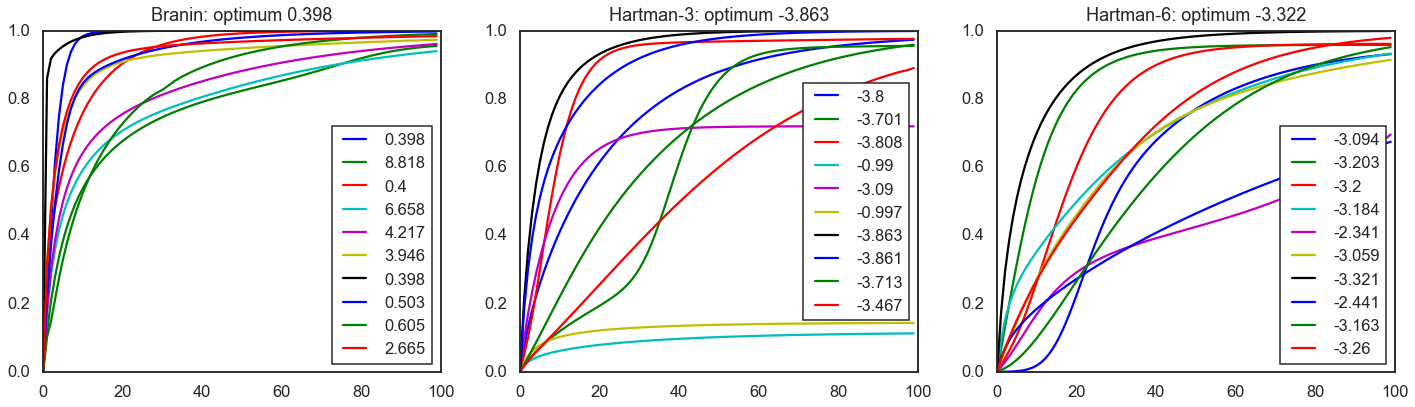

In [226]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(10):
    ax[0].set_title(f'Branin: optimum {round(gd_branin.opt, 3)}', pad=10)
    label = gd_branin.best_values[i].round(3)
    ax[0].plot(gd_branin.gaps[i], label=label)
    ax[0].legend(loc="bottom right")
    ax[0].set_ylim(0, 1)
    
    ax[1].set_title(f'Hartman-3: optimum {round(gd_hartman3.opt, 3)}', pad=10)
    label = gd_hartman3.best_values[i].round(3)
    ax[1].plot(gd_hartman3.gaps[i], label=label)
    ax[1].legend(loc="bottom right")
    ax[1].set_ylim(0, 1)
    
    ax[2].set_title(f'Hartman-6: optimum {round(gd_hartman6.opt, 3)}', pad=10)
    label = gd_hartman6.best_values[i].round(3)
    ax[2].plot(gd_hartman6.gaps[i], label=label)
    ax[2].legend(loc="bottom right")
    ax[2].set_ylim(0, 1)

fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.25)

In each of the plot, we can see the gap evolution over 100 iterations for different runs of the GD algorithm, where the number highlighted in the legend represents the final function value at the last iteration for each trial. The three plots reveal very relevant characteristics of gradient descent. Firstly, for the Branin function, we can see that given only 100 steps this method will not always converge to the optimal value. Although all of the runs of the algorithm seem to be on the correct track to convergence, 100 steps is not enough for all of them. Importantly, the main difference between runs of the algorithm can be attributed to their starting point. When gradient descent starts relatively near to the optimum, it can very quickly get there. However, if this is not the case the convergence can be very slow. 

The picture is different for the two Hartman functions. Focusing on the case of Hartman-3, we can clearly see that several runs of the algorithm converge to a value of the function that is not the optimal. This result aligns with the claim from Hoffman et al. (2011) that gradient-based methods should have difficulties with this type of functions. Nevertheless, there are some runs of the algorithm that are able to get closer to the optimal value of the function. Again, this heterogeneity seems to depend fundamentally on the starting point of the algorithm.

The conclusion that we can draw from here is two-fold:
+ For complicated functions, if the starting point is not optimized gradient descent might get stuck in a local optimum (e.g. Hartman-3 and Hartman-6). Here BO has the advantage of sampling smartly and escaping the local traps of complicated functions
+ Even when the algorithm finds the right path (e.g. Branin), it might take a while to converge. In settings where sampling is expensive, gradient methods might thus not be optimal.

## 5. The best of both worlds: Bayesian optimization and gradient-based methods


In this setting, we have the possibility to have access to approximated gradients for our target functions. 
However, analyzing the dynamics of gradient descent on our three test functions, we have seen that the starting point was key at determining the convergence to the global optimum. This issue was specially salient for the two Hartman functions. The advantage of BO in this setting is that it samples in a smarter way, and should be able to avoid local traps. Our idea was thus to use BO as a method to find potential candidates to start the process of gradient descent.

Below you can find a child class of our two optimization algorithms that implements our strategy. That is, it starts with the GP-Hedge portfolio strategy for sampling the first points, and then implements a gradient descent from there. 

In [ ]:
class Combo(BayesianOptimisation, GradientDescent):
    """ Class combining Bayesian Optimisation (BO) together with Gradient Descent (GD).
        BO is used for a small number of iterations to find an optimal starting point, 
        after which GD algorithm is performed.
    """
    
    def __init__(self, kernel_noise=0.01, method='UCB', obj_func='branin-2', eta=.001, go_iter=5, lr=0.005):
        '''set exploration parameters, optimum value, and GP kernel noise'''
        super(BayesianOptimisation, self).__init__(obj_func=obj_func)
        super(GradientDescent, self).__init__()
        self.method = method
        self.eta = eta
        self.kernel_noise = kernel_noise
        self.obj_func = obj_func
        self.go_iter = go_iter # number of iterations to run BO
        self.lr = lr
        if self.obj_func == 'branin-2':
            self.optimum = 0.39788735775266204
        elif self.obj_func == 'hartman-3':
            self.optimum = -3.8627797869493365
        elif self.obj_func == 'hartman-6':
            self.optimum = -3.322368011391339
        else:
            raise Exception('Invalid objective function!')
        if (method == 'GP_Hedge') | (method == 'GP_Hedge9'):
            self.eta = eta
        
    def train_onesample(self, x_start, n_iters):
        '''training for a specific starting point'''
        self.n_iters = n_iters 
        start = x_start.copy()
        self.x_0 = torch.tensor(start).requires_grad_(True)
        self.optimizer = torch.optim.Adagrad([self.x_0], lr=self.lr)
        self.train()
           
        
    def get_optimum(self, grid_step=100, num_iters=100, samples=25):
        '''for given set of parameters, run BO for go_iter number of iterations,
        then use obtained x values for performing GD for the rest of the run'''
        
        np.random.seed(42)
        results = []
        for _ in range(samples):
            self.kernel = ConstantKernel(1.0, constant_value_bounds = (0.0001, np.inf)) * \
                            RBF(1.0, length_scale_bounds=(0.00001, np.inf))\
                            + WhiteKernel(noise_level=self.kernel_noise, noise_level_bounds='fixed')
            
            if self.method == 'GP_Hedge3':
                self.probabilities = []
                self.gains = np.zeros(3) # 3 obj_funcs
                
            if self.method == 'GP_Hedge9':
                self.probabilities = []
                self.gains = np.zeros(9)
            
            X_ = self.get_grid(step=grid_step)
            if self.obj_func == 'branin-2':
                x1 = [np.random.uniform(-5, 10), np.random.uniform(0, 15)]
            elif self.obj_func == 'hartman-3':
                x1 = np.random.uniform(low=0, high=1, size=3)
            elif self.obj_func == 'hartman-6':
                x1 = np.random.uniform(low=0, high=1, size=6)
            X_train = np.array([x1])
            y_train = [self.get_y(X_train[0]) + np.random.normal(0, .5)]
            f_wo_noise = [self.get_y(X_train[0])]

            f_1 = f_wo_noise[0]
            self.f_0 = f_1
            f_best = max(f_wo_noise)
            gap_0 = (f_best - f_1) / (self.optimum - f_1)
            gap = [gap_0]
            
            GP = GaussianProcessRegressor(kernel=self.kernel, optimizer='fmin_l_bfgs_b', random_state=2)
            
            for t in range(self.go_iter):
                
                GP.fit(X_train, y_train)

                # get canidates
                y_mean, sigma = GP.predict(X_, return_std=True)
                next_x = self.optimize_AF(X_, y_mean, sigma, y_train, t)
                
                # sampling
                X_train = np.vstack((X_train, next_x))
                y_ = self.get_y(next_x) + np.random.normal(0, .5)
                y_train.append(y_)
                f_wo_noise.append(self.get_y(next_x))

                if (self.method == 'GP_Hedge') | (self.method == 'GP_Hedge9'):
                    GP.fit(X_train, y_train)
                    nominees_rewards = GP.predict(self.nominees)
                    self.gains = np.array([gain + nominees_rewards[i] for i, gain in enumerate(self.gains)])

                f_best = max(f_wo_noise)
                gap_t = (f_best - f_1) / (self.optimum - f_1)
                gap.append(gap_t)
            
            if self.obj_func == 'branin-2':
                self.optimum = -0.39788735775266204
            elif self.obj_func == 'hartman-3':
                self.optimum = 3.8627797869493365
            elif self.obj_func == 'hartman-6':
                self.optimum = 3.322368011391339
                
            GP.fit(X_train, y_train)
            y_mean, sigma = GP.predict(X_, return_std=True)
            next_x = self.optimize_AF(X_, y_mean, sigma, y_train, t)
            gd_iter = num_iters-self.go_iter
            self.train_onesample(next_x, n_iters=gd_iter)
            gap = gap + self.gaps_one_sample
            results.append(gap)
        results = np.array(results)
        
        return results.mean(axis=0), results.var(axis=0)

In [245]:
start = datetime.now()
branin_combo = Combo(kernel_noise=0.02, method='GP_Hedge3', eta=.05, obj_func='branin-2', go_iter=20, lr=0.5)
branin_mean_combo, branin_var_combo = branin_combo.get_optimum(samples=10, grid_step=100)

h3_combo = Combo(kernel_noise=0.02, method='GP_Hedge3', eta=.05, obj_func='hartman-3', go_iter=20, lr=0.03)
h3_mean_combo, h3_var_combo = h3_combo.get_optimum(samples=10, grid_step=25)

h6_combo = Combo(kernel_noise=0.02, method='GP_Hedge3', eta=.05, obj_func='hartman-6', go_iter=20, lr=0.03)
h6_mean_combo, h6_var_combo = h6_combo.get_optimum(samples=10, grid_step=5)
print(f'Elapsed time: {datetime.now() - start}')

Elapsed time: 0:00:16.748894


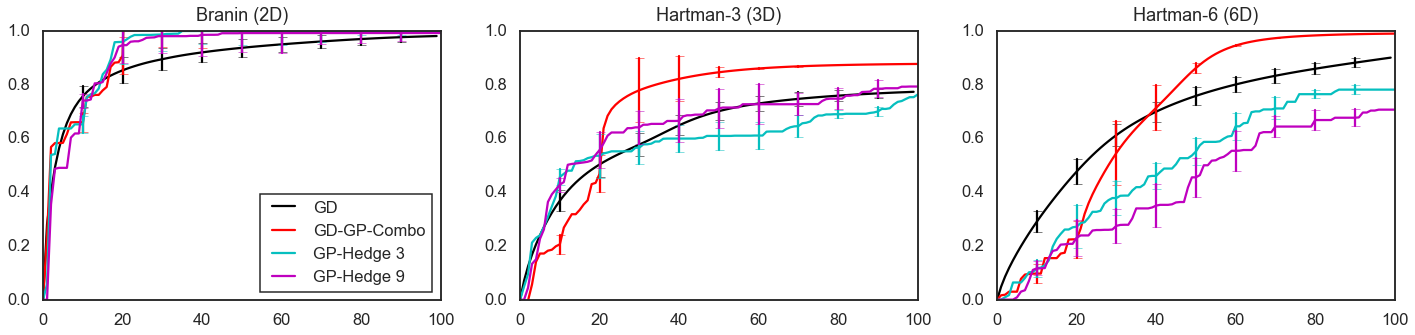

In [246]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

colors = ['#000000', '#FF0100', '#06BFBF', '#BF00BF']
names = ['GD', 'GD-GP-Combo', 'GP-Hedge 3', 'GP-Hedge 9']

branin_means = [branin_mean_gd, branin_mean_combo, branin_mean_hedge3, branin_mean_hedge9]
branin_vars = [branin_var_gd, branin_var_combo, branin_var_hedge3, branin_var_hedge9]

hartman3_means = [h3_mean_gd, h3_mean_combo, h3_mean_hedge3, h3_mean_hedge9]
hartman3_vars = [h3_var_gd, h3_var_combo, h3_var_hedge3, h3_var_hedge9]
        
hartman6_means = [h6_mean_gd, h6_mean_combo, h6_mean_hedge3, h6_mean_hedge9]
hartman6_vars = [h6_var_gd, h6_var_combo, h6_var_hedge3, h6_var_hedge9]
        
func_means = [branin_means, hartman3_means, hartman6_means]
func_vars = [branin_vars, hartman3_vars, hartman6_vars]
titles = ['Branin (2D)', 'Hartman-3 (3D)', 'Hartman-6 (6D)']
for j, means in enumerate(func_means):
    ax[j].set_title(titles[j], pad=10)
    ax[j].set_ylim(0, 1)
    for i, mean in enumerate(means):
        ax[j].plot(mean, label=names[i], c=colors[i])
        for _ in np.arange(10, 100, 10):
            ax[j].axvline(x=_, marker='_', c=colors[i],
                             ymin=mean[_] - hartman6_vars[i][_], 
                             ymax=mean[_] + hartman6_vars[i][_])
ax[0].legend(loc='lower right')
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.25)

In the plot above we can check the performance of our Combo strategy against GP-Hedge-3, GP-Hedge-9 and GD, over 100 iterations and averaged over 10 samples. Results are very interesting. As said, for objective functions in many dimensions the BO algorithm presented the disadvantage of being constrained to search in a quite sparse grid. This hinders the capability of the algorithm to explore the whole space, and makes the exploration advantage of BO less attractive in our case. Also due to this aspect, a simple gradient descent becomes a valid competitor even for the same number of iterations. However, even if for these specific 10 samples gradient descent seems to be on the path for convergence, we know from our analysis that it has the tendency to get completely stuck if it is unluckly with the starting points. Therefore, we implemented a strategy where the first points are sampled via BO, and then gradient descent is applied. Results are indeed striking: our strategy outperforms all others even for the most complicated functions, hinting that for complicated problems where the gradients can be approximated a combination of BO and gradient descent can indeed be an extremely valid option.
